# Painting a Catalog to a Mesh

In this notebook, we outline the process of painting a discrete catalog of objects to a mesh. We discuss some of the most common examples, including the [default behavior](#Painting-the-Overdensity-Field), which paints $1+\delta$, [painting the line-of-sight momentum field](#Painting-the-Line-of-sight-Momentum-Field), and [painting multiple species of particles to the same mesh](#Painting-Multiple-Species-of-Particles).

Each section in this notebook is designed to be stand-alone, providing a full tutorial of the specific topic for users. 

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from nbodykit.lab import *
from nbodykit import style, setup_logging

import matplotlib.pyplot as plt
plt.style.use(style.notebook)

In [3]:
setup_logging() # turn on logging to screen

## Painting the Overdensity Field

When painting a catalog to a mesh, the painted density field is equal to $1+\delta(\mathbf{x})$ when using the default configuration of nbodykit. In this section, we will paint a log-normal mock catalog of objects to a mesh and take a look at some of the properties of the resulting $1+\delta(\mathbf{x})$ field.

To start, we initialize a log-normal mock catalog of unbiased ($b_1=1$) objects at a redshift of $z=0.55$ in a box of side length $L_\mathrm{box} = 1380 \ \mathrm{Mpc}/h$.

In [4]:
redshift = 0.55
cosmo = cosmology.Planck15
Plin = cosmology.LinearPower(cosmo, redshift, transfer='EisensteinHu')

cat = LogNormalCatalog(Plin=Plin, nbar=3e-3, BoxSize=1380., Nmesh=256, bias=1.0, seed=42)

Next, we convert the catalog to a mesh object, using the Triangular Shaped Cloud interpolation window. 

In [5]:
mesh = cat.to_mesh(window='tsc')

The ``paint()`` function returns the painted density field on the mesh, as a ``RealField`` object.

In [6]:
one_plus_delta = mesh.paint(mode='real')
print(type(one_plus_delta))

[ 000022.13 ]   0: 10-23 09:36  CatalogMesh     INFO     painted 7886161 out of 7886161 objects to mesh


[ 000022.14 ]   0: 10-23 09:36  CatalogMesh     INFO     mean particles per cell is 0.470052


[ 000022.14 ]   0: 10-23 09:36  CatalogMesh     INFO     sum is 7.88616e+06 


[ 000022.14 ]   0: 10-23 09:36  CatalogMesh     INFO     normalized the convention to 1 + delta


[ 000022.19 ]   0: 10-23 09:36  CatalogMesh     INFO     field: (LogNormalCatalog(seed=42, bias=1) as CatalogMesh) painting done


<class 'pmesh.pm.RealField'>


The underlying array data of the ``RealField`` object is stored in the ``value`` attribute. Below, we compute the mean, maximum, and minimum of the $1+\delta$ field. As expected, these values are consistent with the properties of the overdensity field $\delta$, specifically $\mathrm{min}(\delta) = -1$ and $\langle \delta \rangle = 0$.

In [7]:
print("mean of 1+delta = ", one_plus_delta.value.mean())
print("min of 1+delta = ", one_plus_delta.value.min())
print("max of 1+delta = ", one_plus_delta.value.max())

mean of 1+delta =  1.0
min of 1+delta =  0.0
max of 1+delta =  17.8592


We can preview a 2D projection of the density field with the ``preview`` function.

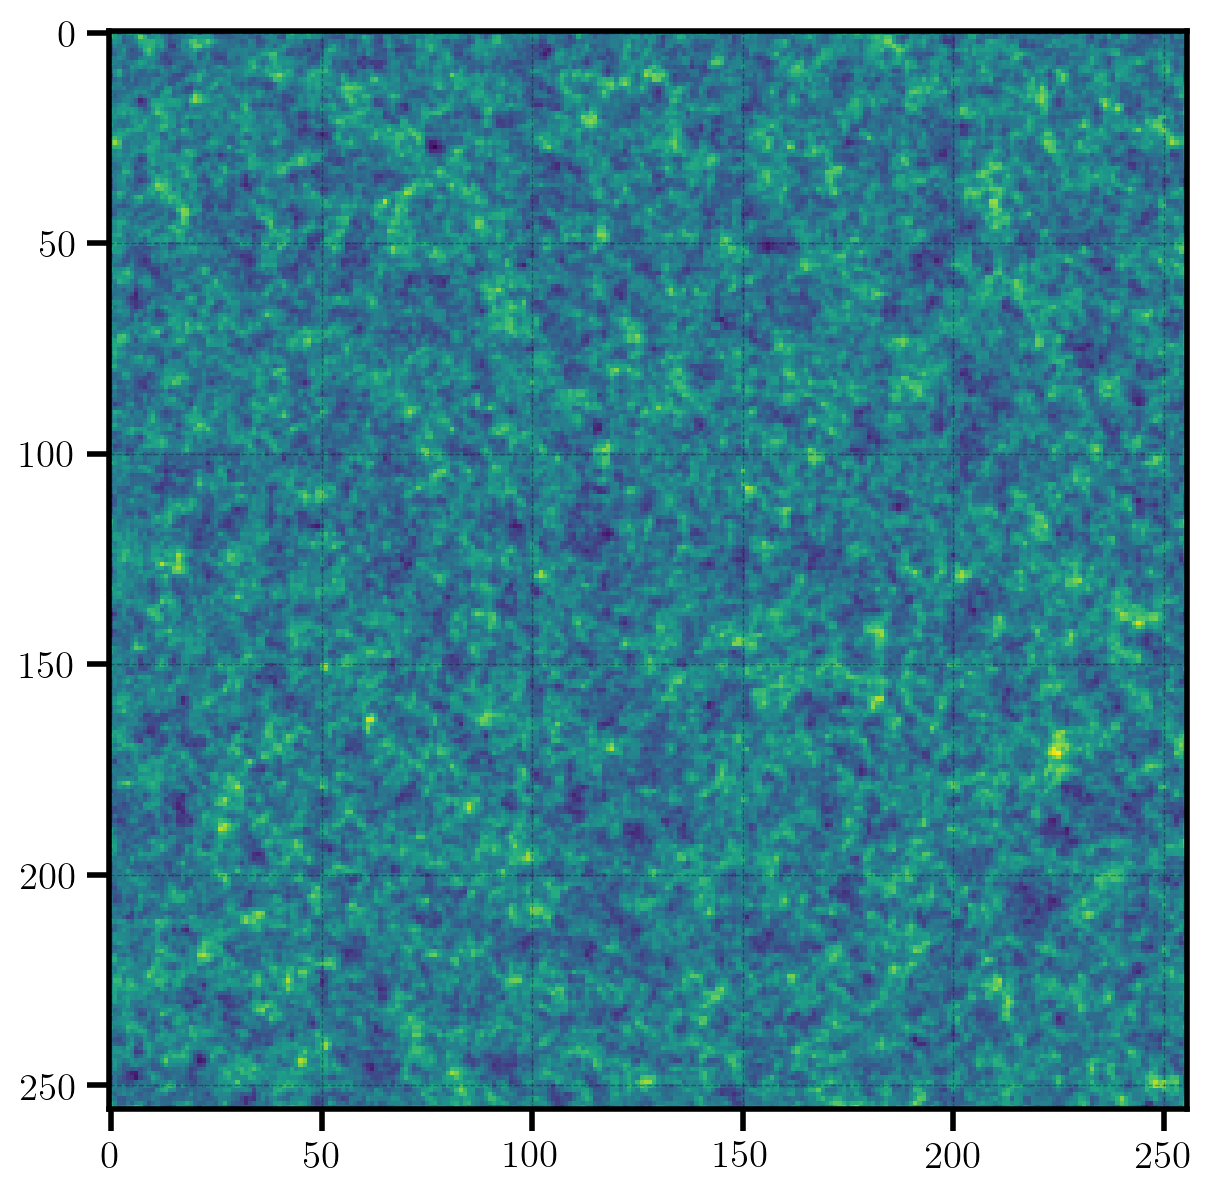

In [8]:
plt.imshow(one_plus_delta.preview(axes=[0,1]))

Finally, we take a look at a 1D histogram of the $1+\delta$ field values in each cell on the mesh. The distribution of values in the $1+\delta$ field very roughly follows a log-normal distribution, providing a semi-realistic representation of the distribution of mass in the true Universe. 

(0.01, 20)

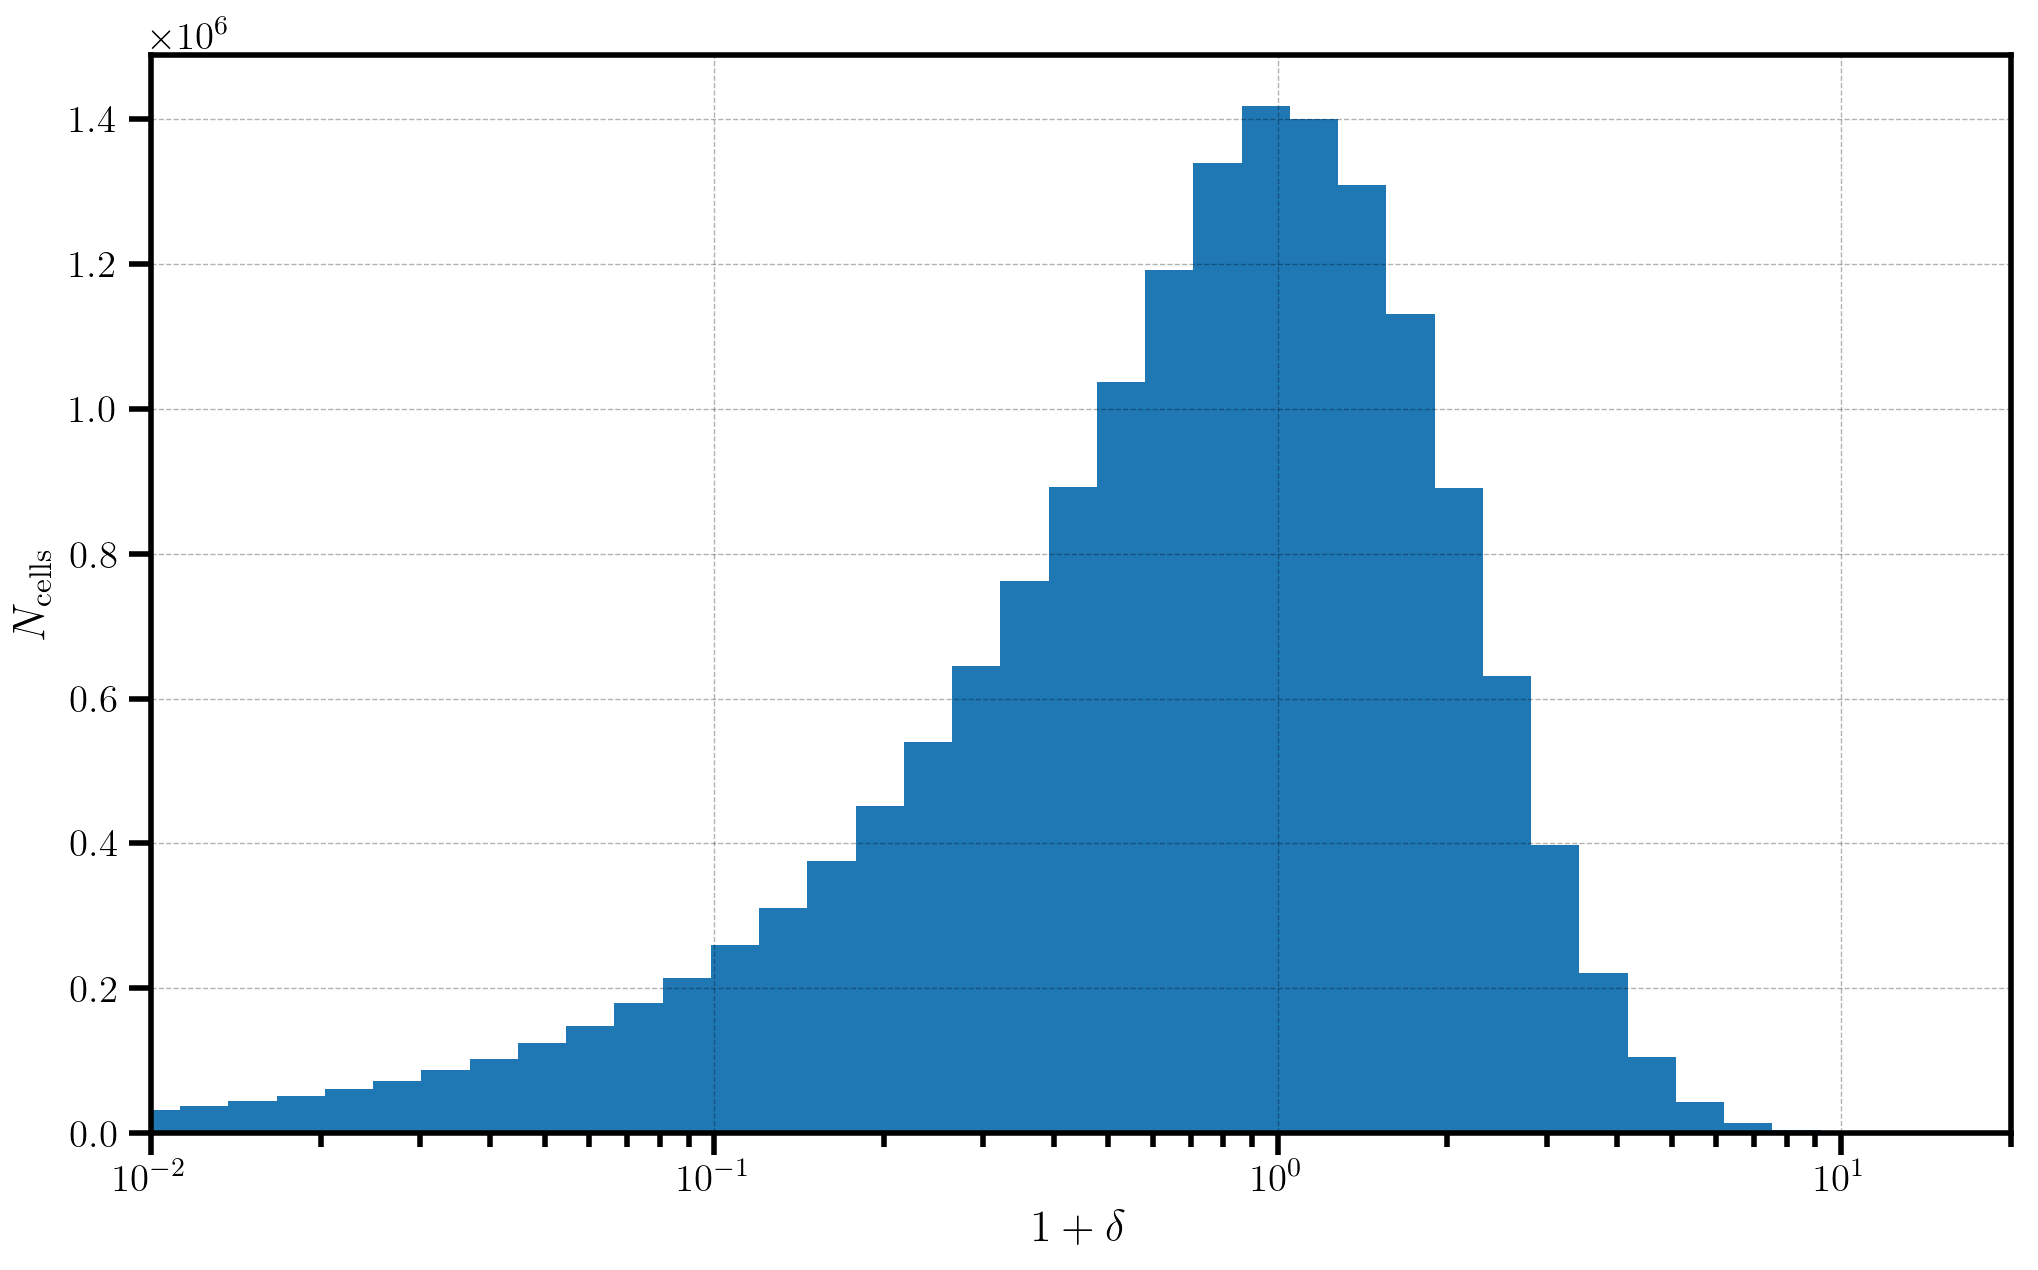

In [9]:
# histogram of 1+delta in log-spaced bins
bins = numpy.logspace(-7, numpy.log10(30.), 100)
_ = plt.hist(one_plus_delta.value.flatten(), bins=bins)

# format the axes
plt.xscale('log')
plt.xlabel(r"$1+\delta$")
plt.ylabel(r"$N_\mathrm{cells}$")
plt.xlim(1e-2, 20)

## Painting the Line-of-sight Momentum Field

In this section, we describe how to use nbodykit to paint the line-of-sight momentum field. The ``paint()`` function paints mass-weighted (or equivalently, number-weighted) quantities to the mesh, as

$$
F(\mathbf{x}) = \left [ 1 + \delta(\mathbf{x}) \right] V(\mathbf{x}),
$$

where $\delta$ is the usual overdensity field and $V(\mathbf{x})$ is the field value. By default, $V(\mathbf{x})$ is equal to unity, such that the field painted is $1+\delta$ (see the [previous section](#Painting-the-Overdensity-Field)). Here, we set the field value $V(\mathbf{x})$ to be the line-of-sight velocity field, $V(\mathbf{x}) = v_\parallel(\mathbf{x})$,
and paint the line-of-sight momentum field (mass-weighted velocity). 

In this section, we compute the cross power spectrum of the momentum field with the density field, the auto spectrum of the momentum field, and the density auto spectrum for a log-normal mock and compare to the corresponding linear predictions for these terms. For more details on these momentum correlators, see [Vlah et al. 2012](https://arxiv.org/abs/1207.0839).

We start by initializing a log-normal mock catalog of unbiased ($b_1=1$) objects at a redshift of $z=0.55$ in a box of side length $L_\mathrm{box} = 1380 \ \mathrm{Mpc}/h$.

In [10]:
redshift = 0.55
cosmo = cosmology.Planck15
Plin = cosmology.LinearPower(cosmo, redshift, transfer='EisensteinHu')

cat = LogNormalCatalog(Plin=Plin, nbar=3e-3, BoxSize=1380., Nmesh=256, bias=1.0, seed=42)

We choose the $x$ axis of the box to be our line-of-sight, and add a column to our catalog holding the $x$ component of the velocity field, properly normalized by the conformal Hubble factor $\mathcal{H}$, where $\mathcal{H} = a H$. We perform this normalization such that the resulting velocity field has units of $\mathrm{Mpc}/h$. Conveniently, the ``VelocityOffset`` column holds the quantity we desire, so we select the first column for the $x$ component.

In [11]:
# line-of-sight is x-axis
LOS = [1, 0, 0]


# this is the velocity / (a*H) 
cat['Vx'] = cat['VelocityOffset'][:,0]  # units are Mpc/h

Next, we convert our catalog to mesh objects in order to paint the momentum and overdensity fields. To paint the momentum, we simply specify the ``value`` keyword as the ``Vx`` column, holding the line-of-sight velocity.

In [12]:
# mesh to paint momentum by specifying "value" keyword
momentum_mesh = cat.to_mesh(compensated=True, window='tsc', position='Position', value='Vx')

# mesh to paint 1+delta by using default value=1.0
mesh = cat.to_mesh(compensated=True, window='tsc', position='Position')

Now, we can use these mesh objects to compute the desired auto and cross spectra of the overdensity and momentum fields using the ``FFTPower`` algorithm. First, we compute the usual density auto spectrum using

In [13]:
# the auto power spectrum of the overdensity field
r00 = FFTPower(mesh, mode='1d', los=[1,0,0])

[ 000047.95 ]   0: 10-23 09:37  CatalogMesh     INFO     painted 7886161 out of 7886161 objects to mesh


[ 000047.95 ]   0: 10-23 09:37  CatalogMesh     INFO     mean particles per cell is 0.470052


[ 000047.95 ]   0: 10-23 09:37  CatalogMesh     INFO     sum is 7.88616e+06 


[ 000047.95 ]   0: 10-23 09:37  CatalogMesh     INFO     normalized the convention to 1 + delta


[ 000048.30 ]   0: 10-23 09:37  CatalogMesh     INFO     field: (LogNormalCatalog(seed=42, bias=1) as CatalogMesh) painting done


Next, we compute the cross power spectrum of the momentum and overdensity fields. The corresponding power spectrum has $\mu$ dependence (see section 3.2 of [Vlah et al. 2012](https://arxiv.org/abs/1207.0839)), so we compute the $\ell=1$ multipole to extract this angular dependence. Note that we also specify the $x$ axis as the line-of-sight to use when determining the $\mu$ coordinate. 

In [14]:
# the cross spectrum of the momentum and density
r01 = FFTPower(momentum_mesh, mode='1d', poles=[1], second=mesh, los=LOS)

[ 000054.40 ]   0: 10-23 09:37  CatalogMesh     INFO     painted 7886161 out of 7886161 objects to mesh


[ 000054.40 ]   0: 10-23 09:37  CatalogMesh     INFO     mean particles per cell is 0.470052


[ 000054.40 ]   0: 10-23 09:37  CatalogMesh     INFO     sum is 13.9668 


[ 000054.40 ]   0: 10-23 09:37  CatalogMesh     INFO     normalized the convention to 1 + delta


[ 000054.74 ]   0: 10-23 09:37  CatalogMesh     INFO     field: (LogNormalCatalog(seed=42, bias=1) as CatalogMesh) painting done


[ 000060.78 ]   0: 10-23 09:37  CatalogMesh     INFO     painted 7886161 out of 7886161 objects to mesh


[ 000060.78 ]   0: 10-23 09:37  CatalogMesh     INFO     mean particles per cell is 0.470052


[ 000060.78 ]   0: 10-23 09:37  CatalogMesh     INFO     sum is 7.88616e+06 


[ 000060.79 ]   0: 10-23 09:37  CatalogMesh     INFO     normalized the convention to 1 + delta


[ 000061.22 ]   0: 10-23 09:37  CatalogMesh     INFO     field: (LogNormalCatalog(seed=42, bias=1) as CatalogMesh) painting done


And finally, we compute the auto power spectrum of the momentum field. We are interested in the $\mu^2$ dependence of the power spectrum (see section 3.2 of [Vlah et al. 2012](https://arxiv.org/abs/1207.0839)), so we compute the $\ell=2$ multipole to extract this angular dependence. 

In [15]:
# the auto spectrum of the momentum field
r11 = FFTPower(momentum_mesh, mode='1d', poles=[2], los=LOS)

[ 000069.50 ]   0: 10-23 09:37  CatalogMesh     INFO     painted 7886161 out of 7886161 objects to mesh


[ 000069.50 ]   0: 10-23 09:37  CatalogMesh     INFO     mean particles per cell is 0.470052


[ 000069.51 ]   0: 10-23 09:37  CatalogMesh     INFO     sum is 13.9668 


[ 000069.51 ]   0: 10-23 09:37  CatalogMesh     INFO     normalized the convention to 1 + delta


[ 000070.04 ]   0: 10-23 09:37  CatalogMesh     INFO     field: (LogNormalCatalog(seed=42, bias=1) as CatalogMesh) painting done


Following [Vlah et al. 2012](https://arxiv.org/abs/1207.0839), we can use these measured momentum correlators to compute their contributions to the redshift-space power spectrum, $P(k,\mu)$. Specifically, we can compute the the first three terms as

$$
P(k,\mu) = P_{00}(k) - 2 i k \mu P_{01}(k,\mu) + k^2 \mu^2 P_{11}(k,\mu).
$$

In linear theory, these terms are given by (see [Kaiser 1987](http://adsabs.harvard.edu/abs/1987MNRAS.227....1K)):

$$
P_\mathrm{lin}(k,\mu) = P_\mathrm{lin}(k) + 2 f \mu^2 P_\mathrm{lin}(k) + f^2 \mu^2 P_\mathrm{lin}(k).
$$

Below, we will compute the contributions to $P(k,\mu)$ from our measured power spectra and compare to their linear counterparts.

In [16]:
# shot noise subtracted density auto spectrum
P00 = r00.power['power'].real - r00.attrs['shotnoise']

The density-momentum cross spectrum has $\mu$ dependence, so the dipole ($\ell=1$) is equal to our desired $P_{01}$. Note that the dipole is imaginary, so we select the imaginary component of the measured spectrum. Finally, we multiply the correct pre-factor of $2 k$. 

Note that the because $P_{01}$ is imaginary, we obtain a real result, as required. Also, note that the final contribution to $P(k,\mu)$ has $\mu^2$ dependence, as expected. 

In [17]:
# density-momentum contribution
P01 = 2 * r01.poles['k'] * r01.poles['power_1'].imag

We are interested in the $\mu^2$ term of the $P_{11}(k,\mu)$ correlator, which can be computed by rescaling the measured $\ell=2$ multipole of the momentum auto spectrum by a factor of $3/2$. We then multiply by the necessary $k^2$ factor from the above equation to obtain the final contribution of the third term to $P(k,\mu)$. 

Note that the final contribution to $P(k,\mu)$ has $\mu^4$ dependence, as expected. 

In [18]:
# momentum auto contribution
P11 = 1.5 * r11.poles['k']**2 * r11.poles['power_2'].real

The linear contributions to $P(k,\mu)$ are given by:

In [19]:
# set up the wavenumbers
k = numpy.logspace(-2, 0, 1000)

# the growth rate at this redshift
f = cosmo.scale_independent_growth_rate(redshift)

# linear first term
P00_lin = Plin(k)

# linear second term
P01_lin = 2*f*P00_lin

# linear third term
P11_lin = f**2 * P00_lin

Finally, we can plot the results and compare!

(0.01, 0.6)

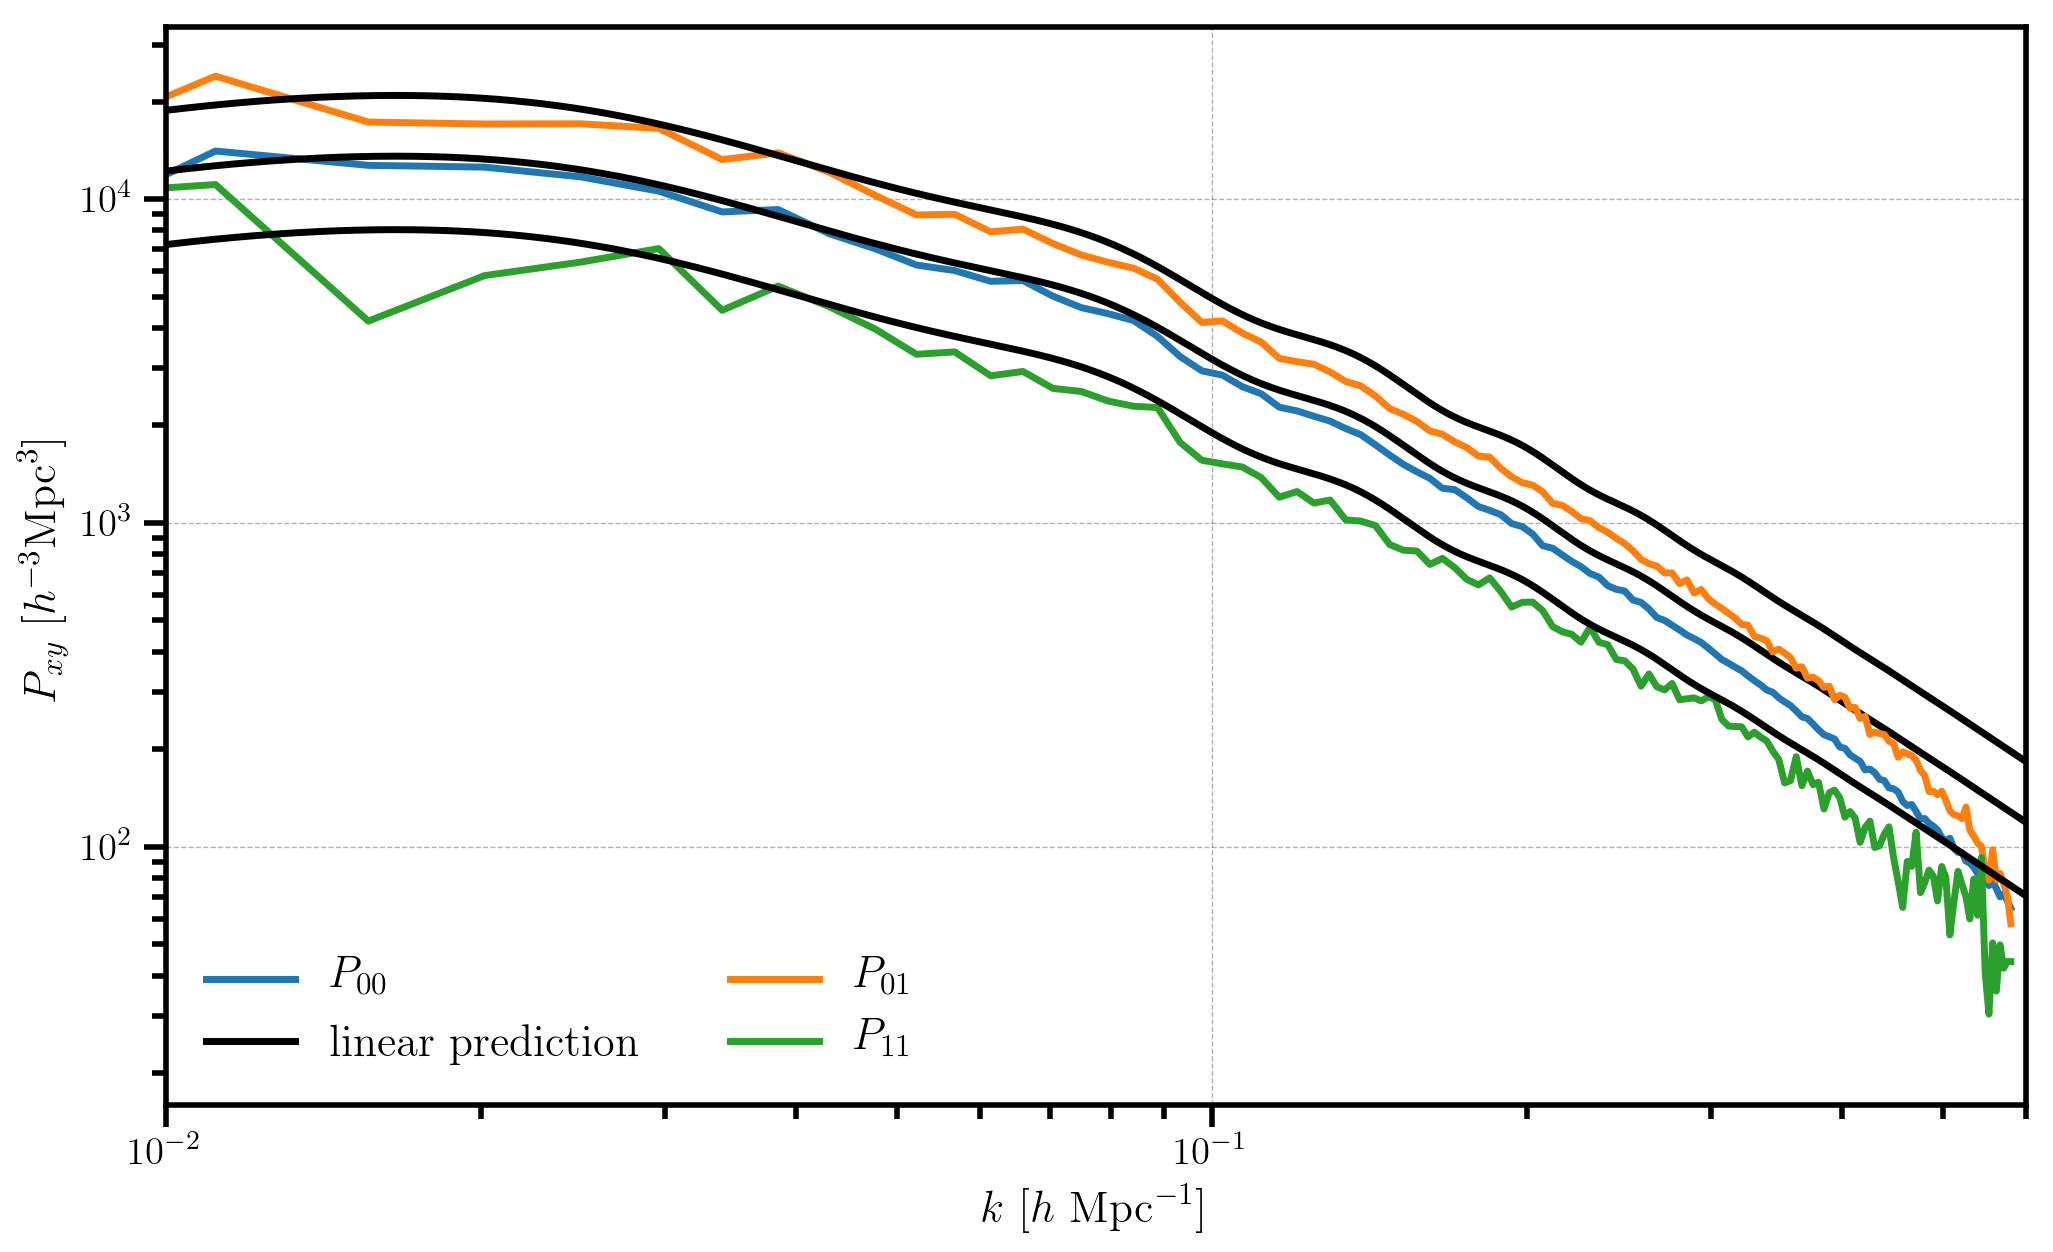

In [20]:
# P00
plt.loglog(r00.power['k'], P00, label=r'$P_{00}$')
plt.loglog(k, P00_lin, c='k', label='linear prediction')

# P01
plt.loglog(r01.power['k'], P01, label=r"$P_{01}$")
plt.loglog(k, P01_lin, c='k')

# P11
plt.loglog(r11.power['k'], P11, label=r"$P_{11}$")
plt.loglog(k, P11_lin, c='k')

# format the axes
plt.legend(loc='lower left', ncol=2)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P_{xy}$ [$h^{-3} \mathrm{Mpc}^3$]")
plt.xlim(0.01, 0.6)

## Painting Multiple Species of Particles

In this section, we generate two "fake" catalogs of data, designed to represent dark matter particles and hydro particles from a cosmological simulation. We assign the two particles different masses, as is often the case in simulations, and paint the catalogs to the same mesh using the ``MultipleSpeciesCatalog`` object. Finally, we compute the combined power spectrum and compare the power spectra of the individual catalogs. 

We begin by generating mock catalogs to represent dark matter and hydro particles of a simulation. We use our log-normal mock generator at a redshift of $z=0.55$ and a box size of $L_\mathrm{box} = 1380 \ \mathrm{Mpc}/h$.

In [21]:
redshift = 0.55
cosmo = cosmology.Planck15
Plin = cosmology.LinearPower(cosmo, redshift, transfer='EisensteinHu')

# the "hydro" particles
hydro = LogNormalCatalog(Plin=Plin, nbar=3e-3, BoxSize=1380., Nmesh=256, bias=2.0, seed=42)

# the "dark matter" particles
dm = LogNormalCatalog(Plin=Plin, nbar=3e-3, BoxSize=1380., Nmesh=256, bias=1.0, seed=84)

Often in simulations, different species of particles will have different masses. Here, we arbitrarily assign the dark matter particles to be 3x as heavy as the hydro particles. We add a new column to each catalog to represent this ``Mass`` column.

In [22]:
hydro['Mass'] = 0.25
dm['Mass'] = 0.75

m_hydro = hydro['Mass']
m_dm = dm['Mass']

We can combine both species of particles into a single catalog using the ``MultipleSpeciesCatalog`` object. This object takes a list of strings giving the names of each species and the individual catalogs. 

In [23]:
combined = MultipleSpeciesCatalog(['hydro', 'dm'], hydro, dm)
print(combined)

MultipleSpeciesCatalog(species=['hydro', 'dm'])


In this combined catalog, the columns for individual species can be accessed by prefixing the name with the name of the species and a forward slash, i.e., "dm/" or "hydro/".

In [24]:
print(combined.columns)

['hydro/Mass', 'hydro/Position', 'hydro/Selection', 'hydro/Value', 'hydro/Velocity', 'hydro/VelocityOffset', 'hydro/Weight', 'dm/Mass', 'dm/Position', 'dm/Selection', 'dm/Value', 'dm/Velocity', 'dm/VelocityOffset', 'dm/Weight']


For example, the mass of the dark matter is set to 0.75 for all dark matter particles.

In [25]:
print(combined['dm/Mass'].compute())

[ 0.75  0.75  0.75 ...,  0.75  0.75  0.75]


And the mass of the hydro particles is set to 0.25.

In [26]:
print(combined['hydro/Mass'].compute())

[ 0.25  0.25  0.25 ...,  0.25  0.25  0.25]


Now, we can convert our catalogs to mesh objects, and specify the ``Mass`` column to be used as the weight value when painting to the mesh. This is done via the ``weight`` keyword of the ``to_mesh()`` function. By specifying ``weight=Mass``, each hydro particle will contribute a value of 0.25 to the mesh and each dark matter particle will contribute a value of 0.75. The resulting density field is normalized as $1+\delta$, using the sum of the densities for each species. 

So, the painted field is:

$$
F(\mathbf{x}) = 1 + \delta_\mathrm{tot}(\mathbf{x}),
$$

where we $\delta_\mathrm{tot}$ is given by

$$
\delta_\mathrm{tot}(\mathbf{x}) = \frac{1}{\bar{n}} \left[ w_\mathrm{dm}(\mathbf{x}) n_\mathrm{dm}(\mathbf{x}) + w_\mathrm{hydro}(\mathbf{x}) n_\mathrm{hydro}(\mathbf{x})\right] - 1,
$$

and the mean density is determined from the sum of each species as

$$
\bar{n} = \langle w_\mathrm{dm}(\mathbf{x}) \rangle \bar{n}_\mathrm{dm} + \langle w_\mathrm{hydro}(\mathbf{x}) \rangle \bar{n}_\mathrm{hydro}.
$$

Here, the mean number density of the particles is assumed to be constant throughout the box, given by the total number of the species divided by the volume.

**Note**

nbodykit supports spatially varying weights, even though in our case, the weights are constant, such that $w_\mathrm{dm}(\mathbf{x}) = 0.75$ and $w_\mathrm{hydro}(\mathbf{x}) = 0.25$.


In [27]:
# the combined mesh, weighted by mass
combined_mesh = combined.to_mesh(Nmesh=256, BoxSize=1380.0, compensated=True, window='tsc', weight='Mass')

# the hydro-only mesh
hydro_mesh = hydro.to_mesh(Nmesh=256, BoxSize=1380.0, compensated=True, window='tsc', weight='Mass')

# the dm-only mesh
dm_mesh = dm.to_mesh(Nmesh=256, BoxSize=1380.0, compensated=True, window='tsc', weight='Mass')

First, compute the 1D power $P(k)$ of the combined mesh of particles.

In [28]:
r_combined = FFTPower(combined_mesh, mode='1d')

[ 000103.44 ]   0: 10-23 09:37  MultipleSpeciesCatalogMesh INFO     painting the 'hydro' species


[ 000108.59 ]   0: 10-23 09:38  CatalogMesh     INFO     painted 7887677 out of 7887677 objects to mesh


[ 000108.59 ]   0: 10-23 09:38  CatalogMesh     INFO     mean particles per cell is 0.117536


[ 000108.59 ]   0: 10-23 09:38  CatalogMesh     INFO     sum is 1.97192e+06 


[ 000108.59 ]   0: 10-23 09:38  CatalogMesh     INFO     normalized the convention to 1 + delta


[ 000108.63 ]   0: 10-23 09:38  MultipleSpeciesCatalogMesh INFO     painting the 'dm' species


[ 000113.63 ]   0: 10-23 09:38  CatalogMesh     INFO     painted 7881785 out of 7881785 objects to mesh


[ 000113.64 ]   0: 10-23 09:38  CatalogMesh     INFO     mean particles per cell is 0.352343


[ 000113.64 ]   0: 10-23 09:38  CatalogMesh     INFO     sum is 7.88326e+06 


[ 000113.64 ]   0: 10-23 09:38  CatalogMesh     INFO     normalized the convention to 1 + delta


[ 000114.05 ]   0: 10-23 09:38  MultipleSpeciesCatalogMesh INFO     field: (MultipleSpeciesCatalog(species=['hydro', 'dm']) as CatalogMesh) painting done


And also compute the dark matter only and hydro only power spectra.

In [29]:
# dark matter only power
r_dm = FFTPower(dm_mesh, mode='1d')

# hydro only power
r_hydro = FFTPower(hydro_mesh, mode='1d')

[ 000120.76 ]   0: 10-23 09:38  CatalogMesh     INFO     painted 7881785 out of 7881785 objects to mesh


[ 000120.77 ]   0: 10-23 09:38  CatalogMesh     INFO     mean particles per cell is 0.352343


[ 000120.77 ]   0: 10-23 09:38  CatalogMesh     INFO     sum is 5.91133e+06 


[ 000120.77 ]   0: 10-23 09:38  CatalogMesh     INFO     normalized the convention to 1 + delta


[ 000121.17 ]   0: 10-23 09:38  CatalogMesh     INFO     field: (LogNormalCatalog(seed=84, bias=1) as CatalogMesh) painting done


[ 000128.13 ]   0: 10-23 09:38  CatalogMesh     INFO     painted 7887677 out of 7887677 objects to mesh


[ 000128.13 ]   0: 10-23 09:38  CatalogMesh     INFO     mean particles per cell is 0.117536


[ 000128.13 ]   0: 10-23 09:38  CatalogMesh     INFO     sum is 1.97192e+06 


[ 000128.14 ]   0: 10-23 09:38  CatalogMesh     INFO     normalized the convention to 1 + delta


[ 000129.02 ]   0: 10-23 09:38  CatalogMesh     INFO     field: (LogNormalCatalog(seed=42, bias=2) as CatalogMesh) painting done


We can express the total overdensity field as a weighted sum of the individual fields:

$$
\delta_\mathrm{tot} = \frac{\alpha_\mathrm{dm}\delta_\mathrm{dm} + \alpha_\mathrm{hydro}\delta_\mathrm{hydro}}{\alpha_\mathrm{dm} + \alpha_\mathrm{hydro}},
$$

where $\alpha_i = \langle w_i \rangle \bar{n}_i$. Using this equation, we can compute the power spectrum of the combined mesh from the individual power spectra as

$$
P_\mathrm{tot}(k) = \left(\frac{\alpha_\mathrm{dm}}{\alpha_\mathrm{dm} + \alpha_\mathrm{hydro}}\right)^2 P_\mathrm{dm} + \left(\frac{\alpha_\mathrm{hydro}}{\alpha_\mathrm{dm} + \alpha_\mathrm{hydro}}\right)^2 P_\mathrm{hydro}.
$$

Note that we have assumed the fields to be un-correlated, which is true in this case, such that there is no cross power spectrum between the fields.

In [30]:
# the individual power spectra
P_dm = r_dm.power['power'].real - r_dm.attrs['shotnoise']
P_hydro = r_hydro.power['power'].real - r_hydro.attrs['shotnoise'] 

# the predicted power spectrum
norm = m_hydro.sum() + m_dm.sum()
Ptot_predicted = (m_hydro.sum()/norm)**2 * P_hydro + (m_dm.sum()/norm)**2 * P_dm 

Now, we compare the individual power spectra, the measured combined power spectrum, and our predicted power spectrum

(0.01, 0.6)

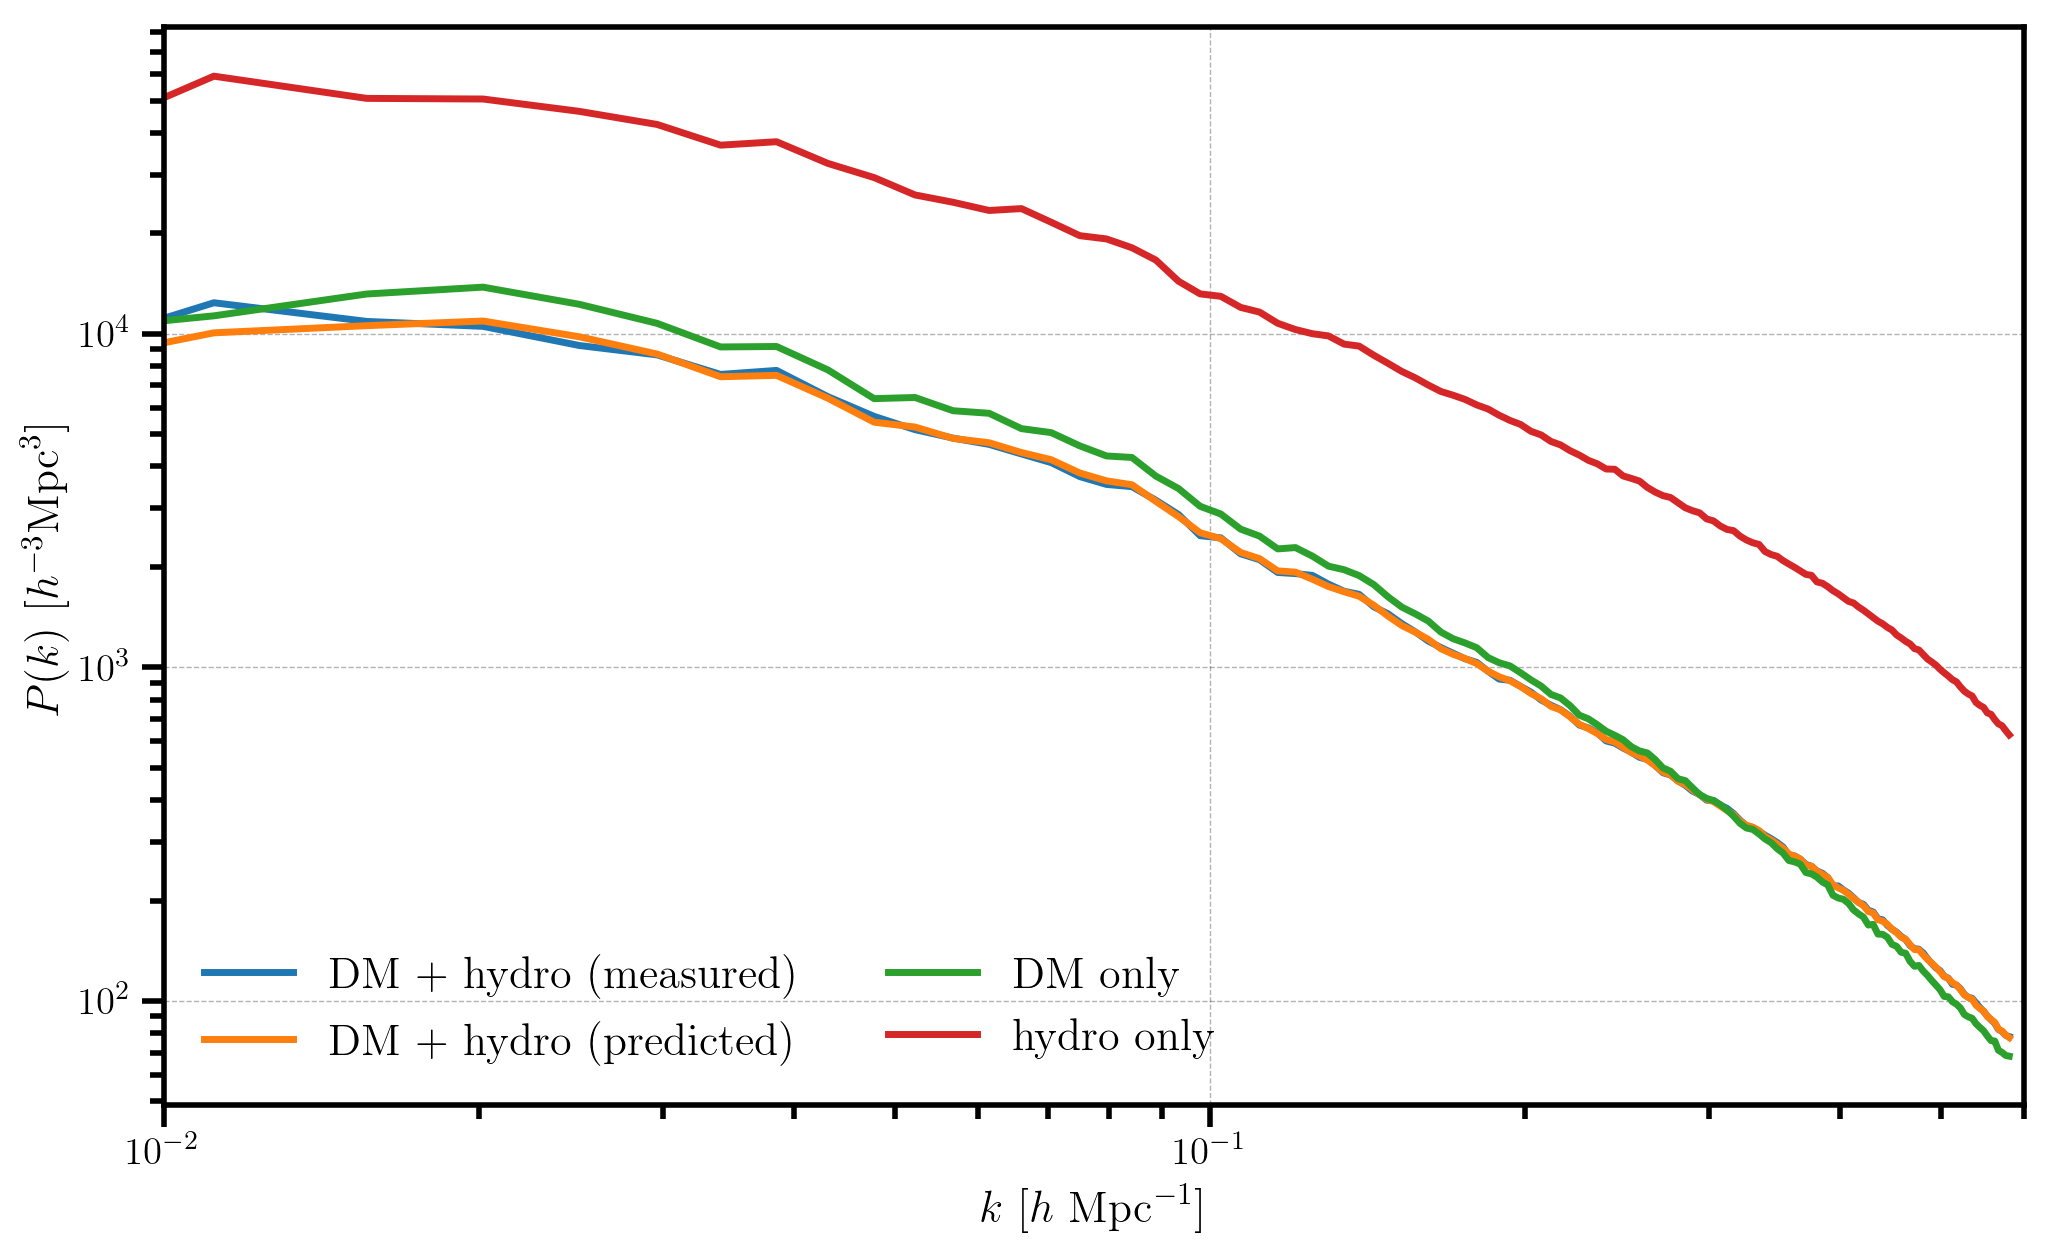

In [31]:
# the measured combined power
Ptot = r_combined.power['power'].real
plt.loglog(r_combined.power['k'], Ptot - r_combined.attrs['shotnoise'], label='DM + hydro (measured)')

# predicted combined power
plt.loglog(r_combined.power['k'], Ptot_predicted, label='DM + hydro (predicted)')

# plot the individual spectra
plt.loglog(r_dm.power['k'], P_dm , label='DM only')
plt.loglog(r_hydro.power['k'], P_hydro, label='hydro only')

# format the axes
plt.legend(loc='lower left', ncol=2)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$ [$h^{-3} \mathrm{Mpc}^3$]")
plt.xlim(0.01, 0.6)

We see that the measured power spectrum for the combined DM + hydro mesh (blue) agrees well with the predicted value computed from the individual power spectra (orange). As expected, the hydro and dark matter only power spectra have similar shapes, but the hydro only power is more strongly biased ($b_1=2$ vs $b_1=1$).